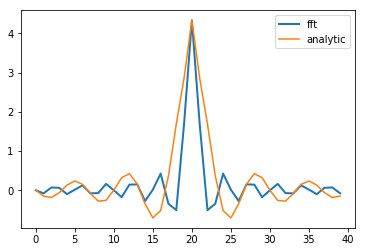

C:\Users\zhaon\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


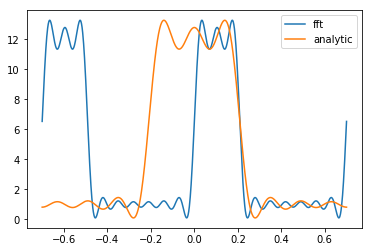

In [1]:
## same as the analytic case but with the fft
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import cond
import cmath;
from scipy.fftpack import fft, fftfreq, fftshift, rfft
from scipy.fftpack import dst, idst
from scipy.linalg import expm
from scipy import linalg as LA

# Moharam et. al Formulation for stable and efficient implementation for RCWA
plt.close("all")
'''
1D TE implementation of PLANAR DIFFRACTiON...the easy case
only: sign convention is exp(-ikr) (is the positive propagating wave), so loss is +  not - 
source for fourier decomps is from the paper: Formulation for stable and efficient implementation of
the rigorous coupled-wave analysis of binary gratings by Moharam et. al
'''
np.set_printoptions(precision = 4)

def grating_fourier_harmonics(order, fill_factor, n_ridge, n_groove):
    """ function comes from analytic solution of a step function in a finite unit cell"""
    #n_ridge = index of refraction of ridge (should be dielectric)
    #n_ridge = index of refraction of groove (air)
    #n_ridge has fill_factor
    #n_groove has (1-fill_factor)
    # there is no lattice constant here, so it implicitly assumes that the lattice constant is 1...which is not good

    if(order == 0):
        return n_ridge**2*fill_factor + n_groove**2*(1-fill_factor);
    else:
        #should it be 1-fill_factor or fill_factor?, should be fill_factor
        return(n_ridge**2 - n_groove**2)*np.sin(np.pi*order*(fill_factor))/(np.pi*order);

def grating_fourier_array(num_ord, fill_factor, n_ridge, n_groove):
    """ what is a convolution in 1D """
    fourier_comps = list();
    for i in range(-num_ord, num_ord+1):
        fourier_comps.append(grating_fourier_harmonics(i, fill_factor, n_ridge, n_groove));
    return fourier_comps;

def fourier_reconstruction(x, period, num_ord, n_ridge, n_groove, fill_factor = 0.5):
    index = np.arange(-num_ord, num_ord+1);
    f = 0;
    for n in index:
        coef = grating_fourier_harmonics(n, fill_factor, n_ridge, n_groove);
        f+= coef*np.exp(cmath.sqrt(-1)*np.pi*n*x/period);
        #f+=coef*np.cos(np.pi*n*x/period)
    return f;

def fourier_reconstruction_general(x, period, num_ord, coefs):
    '''
    overloading odesn't work in python...fun fact, since it is dynamically typed (vs statically typed)
    :param x:
    :param period:
    :param num_ord:
    :param coefs:
    :return:
    '''
    index = np.arange(-num_ord, num_ord+1);
    f = 0; center = int(len(coefs)/2); #no offset
    for n in index:
        coef = coefs[center+n];
        f+= coef*np.exp(cmath.sqrt(-1)*2*np.pi*n*x/period);
    return f;

def grating_fft(eps_r):
    assert len(eps_r.shape) == 2
    assert eps_r.shape[1] == 1;
    #eps_r: discrete 1D grid of the epsilon profile of the structure
    fourier_comp = np.fft.fftshift(np.fft.fft(eps_r, axis = 0)/eps_r.shape[0]);
    #ortho norm in fft will do a 1/sqrt(n) scaling
    return np.squeeze(fourier_comp);

# plt.plot(x, np.real(fourier_reconstruction(x, period, 1000, 1,np.sqrt(12), fill_factor = 0.1)));
# plt.title('check that the analytic fourier series works')
# #'note that the lattice constant tells you the length of the ridge'
# plt.show()

L0 = 1e-6;
e0 = 8.854e-12;
mu0 = 4*np.pi*1e-8;
fill_factor = 0.3; # 50% of the unit cell is the ridge material


num_ord = 10; #INCREASING NUMBER OF ORDERS SEEMS TO CAUSE THIS THING TO FAIL, to many orders induce evanescence...particularly
               # when there is a small fill factor
PQ = 2*num_ord+1;
indices = np.arange(-num_ord, num_ord+1)

n_ridge = 3.48; #3.48;              # ridge
n_groove = 1;                # groove (unit-less)
lattice_constant = 0.7;  # SI units
# we need to be careful about what lattice constant means
# in the gaylord paper, lattice constant exactly means (0, L) is one unit cell


d = 0.46;               # thickness, SI units
Nx = 2*256;
eps_r = n_groove**2*np.ones((2*Nx, 1)); #put in a lot of points in eps_r
border = int(2*Nx*fill_factor);
eps_r[0:border] = n_ridge**2;
fft_fourier_array = grating_fft(eps_r);
x = np.linspace(-lattice_constant,lattice_constant,1000);
period = lattice_constant;
fft_reconstruct = fourier_reconstruction_general(x, period, num_ord, fft_fourier_array);

fourier_array_analytic = grating_fourier_array(Nx, fill_factor, n_ridge, n_groove);
analytic_reconstruct = fourier_reconstruction(x, period, num_ord, n_ridge, n_groove, fill_factor)


plt.figure();
plt.plot(np.real(fft_fourier_array[Nx-20:Nx+20]), linewidth=2)
plt.plot(np.real(fourier_array_analytic[Nx-20:Nx+20]));
plt.legend(('fft', 'analytic'))
plt.show()

plt.figure();
plt.plot(x,fft_reconstruct)
plt.plot(x,analytic_reconstruct);
plt.legend(['fft', 'analytic'])
plt.show()

## simulation parameters
theta = (0)*np.pi/180;


## construct permittivity harmonic components E
#fill factor = 0 is complete dielectric, 1 is air

##construct convolution matrix
E = np.zeros((2 * num_ord + 1, 2 * num_ord + 1)); E = E.astype('complex')
p0 = Nx; #int(Nx/2);
p_index = np.arange(-num_ord, num_ord + 1);
q_index = np.arange(-num_ord, num_ord + 1);
fourier_array = fft_fourier_array;#fourier_array_analytic;
detected_pffts = np.zeros_like(E);
for prow in range(2 * num_ord + 1):
    # first term locates z plane, 2nd locates y coumn, prow locates x
    row_index = p_index[prow];
    for pcol in range(2 * num_ord + 1):
        pfft = p_index[prow] - p_index[pcol];
        detected_pffts[prow, pcol] = pfft;
        E[prow, pcol] = fourier_array[p0 + pfft];  # fill conv matrix from top left to top right

## IMPORTANT TO NOTE: the indices for everything beyond this points are indexed from -num_ord to num_ord+1








True


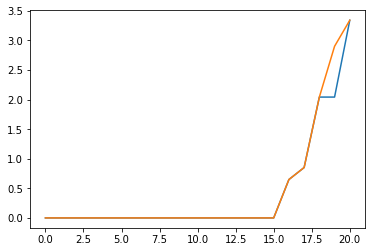

True


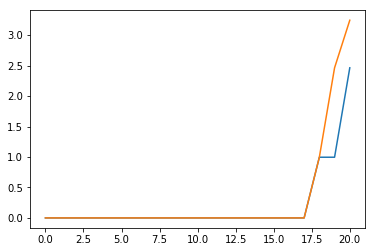

True


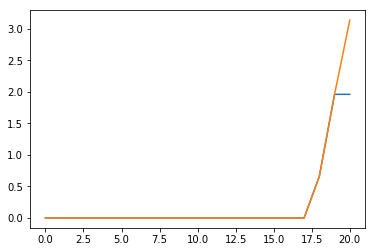

True


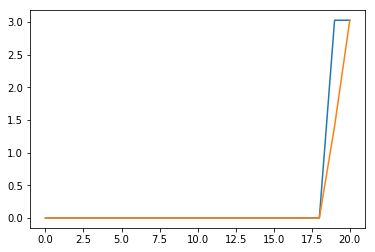

True


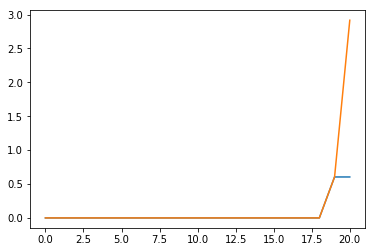

True


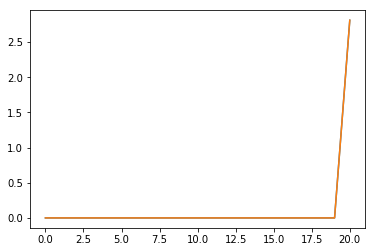

True


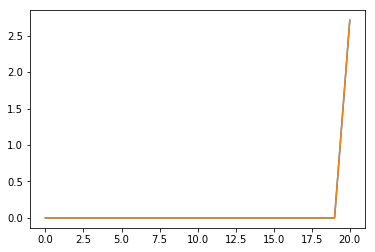

True


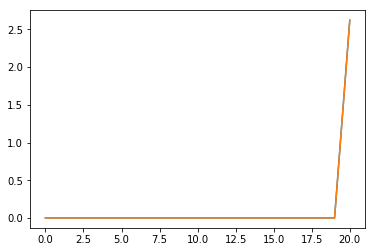

True


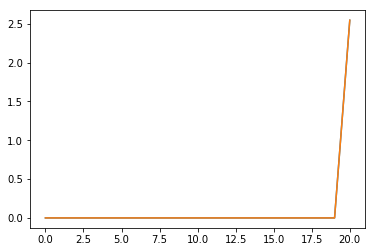

True


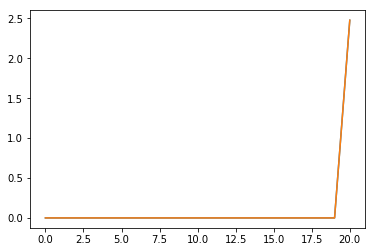

In [129]:
## alternate construction of 1D convolution matrix
spectra = list();
spectra_T = list();
I = np.identity(2 * num_ord + 1)
PQ = 2*num_ord+1;
zeros = np.zeros((PQ, PQ))
# E is now the convolution of fourier amplitudes
wavelength_scan = np.linspace(0.5,2.3,10)

for wvlen in wavelength_scan:
    j = cmath.sqrt(-1);
    lam0 = wvlen;     k0 = 2 * np.pi / lam0; #free space wavelength in SI units
    #print('wavelength: ' + str(wvlen));
    ## =====================STRUCTURE======================##

    ## Region I: reflected region (half space)
    n1 = 1;#cmath.sqrt(-1)*1e-12; #apparently small complex perturbations are bad in Region 1, these shouldn't be necessary

    ## Region 2; transmitted region
    n2 = 1;

    #from the kx_components given the indices and wvln
    kx_array = k0*(n1*np.sin(theta) + indices*(lam0 / lattice_constant)); #0 is one of them, k0*lam0 = 2*pi
    k_xi = kx_array;
    ## IMPLEMENT SCALING: these are the fourier orders of the x-direction decomposition.
    KX = np.diag(kx_array/k0);
    KX2 = np.diag(np.power((k_xi/k0),2)); #singular since we have a n=0, m= 0 order and incidence is normal

    
    ## construct matrix of Gamma^2 ('constant' term in ODE):
    A = KX2 - E; #conditioning of this matrix is not bad, A SHOULD BE SYMMETRIC
    #sum of a symmetric matrix and a diagonal matrix should be symmetric;
    AO = np.block([[zeros, I],[A, zeros]])
    beigenvals, bigW = LA.eig(AO);
    
    ## SORTING IS REQUIRED
    #sorting procedure is to order by smallest imaginary part to largest imaginary part
    # however, it's not clear to me that this is correct
    # in the Fourier expansion
    sorted_reals = np.argsort(np.real(beigenvals))
    sorted_imags = np.argsort(np.real(beigenvals));
    print(np.array_equal(sorted_reals,sorted_imags))
    
    sorted_eigenmodes = bigW[:,sorted_imags];
    sorted_eigenvals = beigenvals[sorted_imags];
    Wp = sorted_eigenmodes[PQ:, PQ:]
    
    eigenvals_wp = (sorted_eigenvals[0:PQ]);
    #print(eigenvals_wp.shape)
    #plt.plot(np.imag(sorted_eigenvals));
    #plt.show()
    ##
    # when we calculate eigenvals, how do we know the eigenvals correspond to each particular fourier order?
    eigenvals, W = LA.eigh(A); #A should be symmetric or hermitian
    
    # clearly, there is a mismatch between order of eigenvalues, which we have to fix...
    
    W = Wp;
    #we should be gauranteed that all eigenvals are REAL
    eigenvals = eigenvals.astype('complex');
    Q = np.diag(np.sqrt(eigenvals)); #Q should only be positive square root of eigenvals
    #real parts match, but the imaginaries don't
    
#     plt.plot(sorted(np.abs(np.real(eigenvals_wp))))
#     plt.plot((np.real(np.diag(Q))))
#     plt.show();
    
    plt.plot(sorted(np.abs(np.imag(eigenvals_wp))))
    plt.plot(sorted(np.abs((np.imag(np.diag(Q))))))
    plt.show();
    #plt.plot(np.imag(np.diag(Q)))
    #plt.show()
    V = W@Q; #H modes

    X = np.diag(np.exp(-k0*np.diag(Q)*d)); #this is poorly conditioned because exponentiation
    ## pointwise exponentiation vs exponentiating a matrix

    ## observation: almost everything beyond this point is worse conditioned
    k_I = k0**2*(n1**2 - (k_xi/k0)**2);                 #k_z in reflected region k_I,zi
    k_II = k0**2*(n2**2 - (k_xi/k0)**2);   #k_z in transmitted region
    k_I = k_I.astype('complex'); k_I = np.sqrt(k_I);
    k_II = k_II.astype('complex'); k_II = np.sqrt(k_II);
    Y_I = np.diag(k_I/k0);
    Y_II = np.diag(k_II/k0);


    delta_i0 = np.zeros((len(kx_array),1));
    delta_i0[num_ord] = 1;
    n_delta_i0 = delta_i0*j*n1*np.cos(theta); #this is a VECTOR

    ## design auxiliary variables: SEE derivation in notebooks: RCWA_note.ipynb
    # we want to design the computation to avoid operating with X, particularly with inverses
    # since X is the worst conditioned thing

    Wi = np.linalg.inv(W);
    Vi = np.linalg.inv(V);
    Oi = 0.5*np.block([[Wi, Vi],[Wi, -Vi]])
    f = I;
    g = j*Y_II; #all matrices
    fg = np.concatenate((f,g),axis = 0)
    #ab = np.matmul(np.linalg.inv(O),fg);
    # ab = np.matmul(Oi, fg);
    # a = ab[0:PQ,:];
    # b = ab[PQ:,:];

    a = 0.5*(Wi+j*Vi@Y_II);
    b = 0.5*(Wi-j*Vi@Y_II);
    fbiX = np.matmul(np.linalg.inv(b),X)

    #altTerm = (a@X@X@b); #not well conditioned and I-altTermis is also poorly conditioned.
    #print(np.linalg.cond(I-np.linalg.inv(altTerm)))
    #print(np.linalg.cond(X@b)); #not well conditioned.

    term = X@a@fbiX; # THIS IS SHITTILY CONDITIONED
    # print((np.linalg.cond(X), np.linalg.cond(term)))
    # print(np.linalg.cond(I+term)); #but this is EXTREMELY WELL CONDITIONED.
    f = np.matmul(W, I+term);
    g = np.matmul(V,-I+term);
    T = np.linalg.inv(j*np.matmul(Y_I,f)+g);
    T = np.matmul(T,(np.matmul(j*Y_I,delta_i0)+n_delta_i0));
    R = np.matmul(f,T)-delta_i0;
    T = np.matmul(fbiX, T)

    ## calculate diffraction efficiencies
    #I would expect this number to be real...
    DE_ri = R*np.conj(R)*np.real(np.expand_dims(k_I,1))/(k0*n1*np.cos(theta));
    DE_ti = T*np.conj(T)*np.real(np.expand_dims(k_II,1))/(k0*n1*np.cos(theta));
    #print(np.sum(DE_ri))

    #print(np.sum(DE_ri))
    spectra.append(np.sum(DE_ri)); #spectra_T.append(T);
    spectra_T.append(np.sum(DE_ti))




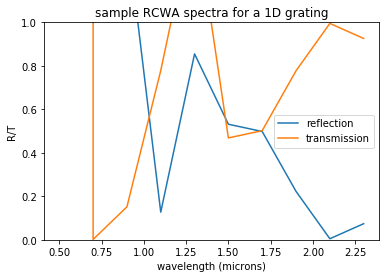

In [125]:

plt.figure();
plt.plot(wavelength_scan, np.abs(spectra));
plt.plot(wavelength_scan, np.abs(spectra_T))
plt.xlabel('wavelength (microns)')
plt.ylabel('R/T')
plt.title('sample RCWA spectra for a 1D grating')
plt.legend(['reflection', 'transmission'])
# plt.axhline(((3.48-1)/(3.48+1))**2,xmin=0, xmax = max(wavelength_scan))
# plt.axhline(((3.48-1)/(3.48+1)),xmin=0, xmax = max(wavelength_scan), color='r')
plt.ylim([0,1])
plt.show()